In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
# select/limit gpu availability to a single device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import sys, os, warnings, time, logging
from functools import partial
import copy
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.core.decorators import auto_move_data
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from einops import rearrange, repeat

import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm.autonotebook import tqdm

from lightning_addons.progressbar import ProgressBar
from lightning_addons.progressplotter import ProgressPlotter
from lightning_addons.progressprinter import ProgressPrinter

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
# this makes lightning reports not look like errors
pl._logger.handlers = [logging.StreamHandler(sys.stdout)]

print("python", sys.version, sys.executable)
print("pytorch", torch.__version__)
print("torchvision", torchvision.__version__)
print("pytorch-lightning", pl.__version__)

python 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0] /home/mtadmin/miniconda3/envs/dev_pytorch18/bin/python
pytorch 1.8.0
torchvision 0.9.0
pytorch-lightning 1.2.4


In [4]:
def to_3channel(image):
    return image.repeat((3, 1, 1))

## mnist

In [5]:
class MnistDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, n_workers, train_fraction=0.7, extra_transforms=None, data_dir="data/mnist"):
        super().__init__()
        self.batch_size = batch_size
        self.n_workers = n_workers
        self.train_fraction = train_fraction
        self.data_dir = data_dir
        transforms = [torchvision.transforms.ToTensor(),]
        if extra_transforms is not None:
            transforms += extra_transforms
        self.transform = torchvision.transforms.Compose(transforms)
        
    def prepare_data(self):
        # this is intended to just run the download
        torchvision.datasets.MNIST(self.data_dir, download=True, train=True)
        torchvision.datasets.MNIST(self.data_dir, download=True, train=False)
        
    def setup(self, stage=None):
        # this can potentially be run on different machines and GPUs hence the actual preperation should be done here
        if stage == "fit" or stage is None:
            trainval_data = torchvision.datasets.MNIST(self.data_dir, train=True, transform=self.transform)
            n_trainval = len(trainval_data)
            n_train = int(self.train_fraction * n_trainval)
            self.train_data = torch.utils.data.Subset(trainval_data, range(0, n_train))
            self.val_data = torch.utils.data.Subset(trainval_data, range(n_train, n_trainval))
            # if we set this here we get the actual transformed size, which is nice at it does not require prior knowledge as in __init__()
            self.dims = tuple(self.train_data[0][0].shape)
        if stage == "test" or stage is None:
            self.test_data = torchvision.datasets.MNIST(self.data_dir, train=False, transform=self.transform)
            self.dims = tuple(self.test_data[0][0].shape)
        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_data, batch_size=self.batch_size, num_workers=self.n_workers, shuffle=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_data, batch_size=self.batch_size, num_workers=self.n_workers)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_data, batch_size=self.batch_size, num_workers=self.n_workers)

output_size = 28

# data standard normalization parameters:
# to compute mean and std
# norm_mean = 0.
# norm_std = 1.
# default
# norm_mean = 0.5
# norm_std = 0.5
# imagenet
# norm_mean = [0.485, 0.456, 0.406]
# norm_std = [0.229, 0.224, 0.225]
# mnist 
norm_mean = [0.1311, 0.1311, 0.1311]
norm_std = [0.3087, 0.3087, 0.3087]

# TODO: we can do better by actually computing these values from mnist
extra_transforms = [
    torchvision.transforms.Resize(output_size),
    to_3channel,  # we use 3 channels to directly use (pretrained) ResNets
    torchvision.transforms.Normalize(norm_mean, norm_std),
]
mnist_data = MnistDataModule(32, 8, extra_transforms=extra_transforms)
mnist_data.prepare_data()
mnist_data.setup()
mnist_data.size(), len(mnist_data.train_dataloader().dataset), len(mnist_data.val_dataloader().dataset), len(mnist_data.test_dataloader().dataset)

((3, 28, 28), 42000, 18000, 10000)

## select dataset

In [6]:
data = mnist_data

## compute normalization stats

In [7]:
# # compute mean and std etc
# input_key = 0
# def collect_stats(sample):
#     image = sample[input_key]
#     return image.sum((1, 2)), (image ** 2).sum((1, 2))#, image.mean((1, 2)), image.min((1, 2)), image.max((1, 2))

# all_stats = [collect_stats(sample) for sample in tqdm(data.train_dataloader().dataset)]
# sums, squared_sums= [torch.stack(stats, 0) for stats in (zip(*all_stats))]
# # # , means, mins, maxs 
# input_shape = data.train_dataloader().dataset[0][input_key].shape
# input_area = input_shape[1] * input_shape[2]

# ds_mean = sums.mean(0) / input_area
# ds_std = (squared_sums.mean(0) / input_area - ds_mean ** 2).sqrt()
# ds_mean, ds_std

## check samples

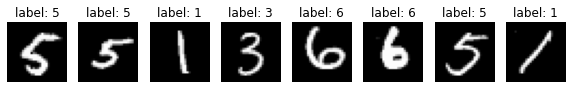

In [8]:
dataloader = data.train_dataloader()
batch = next(iter(dataloader))
# 0: input, 1: target
n_samples = 8
f, axs = plt.subplots(1, n_samples, figsize=(10, 5))
for i, ax in enumerate(axs):
    sample_image = batch[0][i]
    sample_target = batch[1][i]
    ax.imshow(sample_image.permute(1, 2, 0).mul(torch.as_tensor(norm_std)).add(torch.as_tensor(norm_mean)).clamp(0.0, 1.0))
    ax.set_title(f"label: {sample_target.numpy()}");
    ax.axis(False);

## resnet model

In [9]:
class ResNetModel(pl.LightningModule):
    def __init__(self, data_shape, num_classes, 
                 learning_rate, momentum=0.9, weight_decay=5e-4,
                 pretrained=False, activation="softmax", sigmoid_soft_factor=1.0, scheduler="one_cycle"):
        super().__init__()
        self.save_hyperparameters()

        # torchvision's resnet18 does not allow pretraining for num_classes != 1000
        assert pretrained == False
        self.resnet = torchvision.models.resnet18(num_classes=num_classes)
    
#         # to use pretraining simply replace last linear layer with one mathcing num_classes
#         self.resnet = torchvision.models.resnet18(pretrained=pretrained)
#         self.resnet.fc = torch.nn.Linear(512, 10)
        
        # this allows the trainer to show input and output sizes in the report (1 is just a sample batch size)
        self.example_input_array = torch.zeros(1, *data_shape)
        
        self.train_acc = pl.metrics.Accuracy(compute_on_step=False)
        self.val_acc = pl.metrics.Accuracy(compute_on_step=False)
        self.test_acc = pl.metrics.Accuracy(compute_on_step=False)
        self.test_confmatrix = pl.metrics.ConfusionMatrix(num_classes, compute_on_step=False)
        
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate, momentum=self.hparams.momentum, weight_decay=self.hparams.weight_decay)
        schedulers = []
        if self.hparams.scheduler == "one_cycle":
            steps_per_epoch = int(self.trainer.limit_train_batches * len(self.train_dataloader())) # same as batches per epoch
            max_epochs = self.trainer.max_epochs
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=self.hparams.learning_rate,
                epochs=max_epochs,
                steps_per_epoch=steps_per_epoch,
                anneal_strategy="cos", # can be "linear" or "cos"(default)
                three_phase=False,
            )
            # "interval: step" is required to let the scheduler update per step rather than epoch
            schedulers = [{"scheduler": scheduler, "interval": "step", "frequency": 1}]
        elif self.hparams.scheduler == "cosine_annealing":
            steps_per_epoch = int(self.trainer.limit_train_batches * len(self.train_dataloader())) # same as batches per epoch
            max_epochs = self.trainer.max_epochs
            max_steps = max_epochs * steps_per_epoch
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=max_steps,
            )
            schedulers = [{"scheduler": scheduler, "interval": "step", "frequency": 1}]
        elif isinstance(self.hparams.scheduler, type) or isinstance(self.hparams.scheduler, partial):
            schedulers = [self.hparams.scheduler(optimizer)]
        return [optimizer], schedulers
    
    def class_activation(self, x):
        if self.hparams.activation == "softmax":
            return x.softmax(1)
        elif self.hparams.activation == "sigmoid":
            return x.sigmoid()
        
    def class_loss(self, y_hat, y):
        # y_hat: prediction, y: target
        if self.hparams.activation == "softmax":
            return torch.nn.functional.cross_entropy(y_hat, y)
        elif self.hparams.activation == "sigmoid":
            y = y.float()
            y = y * self.hparams.sigmoid_soft_factor
            y[y == 0] = (1.0 - self.hparams.sigmoid_soft_factor) / (self.hparams.num_classes - 1)
            return torch.nn.functional.binary_cross_entropy_with_logits(y_hat, y)
    
    def _forward(self, x):
        return self.resnet(x)
    
    def training_step(self, batch, batch_nb):
        images, targets = batch
        if self.hparams.activation == "sigmoid":
            targets = torch.nn.functional.one_hot(targets, num_classes=self.hparams.num_classes)
        
        preds = self._forward(images)
        loss = self.class_loss(preds, targets)
        self.log("loss", loss)
        self.train_acc.update(self.class_activation(preds), targets)
        # the accuracies are updated here, but only computed and reported at the epoch, see "compute_on_step=False", "on_step=False", "on_epoch=True"
        self.log('train_acc', self.train_acc, prog_bar=False, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_nb):
        images, targets = batch
        if self.hparams.activation == "sigmoid":
            targets = torch.nn.functional.one_hot(targets, num_classes=self.hparams.num_classes)
        
        preds = self._forward(images)
        loss = self.class_loss(preds, targets)
        self.log("val_loss", loss)
        self.val_acc.update(self.class_activation(preds), targets)
        self.log('val_acc', self.val_acc, prog_bar=False, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_nb):
        images, targets = batch
        if self.hparams.activation == "sigmoid":
            targets = torch.nn.functional.one_hot(targets, num_classes=self.hparams.num_classes)
        
        preds = self._forward(images)
        loss = self.class_loss(preds, targets)
        self.log("test_loss", loss)
        self.test_acc.update(self.class_activation(preds), targets)
        self.log('test_acc', self.test_acc, prog_bar=False, on_step=False, on_epoch=True)
        self.test_confmatrix.update(self.class_activation(preds), targets)
        return loss
    
    # this moves data to gpu when forward is called
    @auto_move_data
    def forward(self, x):
        # in pl forward() is intended for inference, hence the activation is done here
        logits = self._forward(x)
        return self.class_activation(logits)

num_classes = 10
learning_rate = 1e-1
# momentum = 0
# weight_decay = 0
momentum = 0.9
weight_decay = 5e-4
pretrained = False
activation = "softmax"
# activation = "sigmoid"
sigmoid_soft_factor = 0.9 # soft label: this is a multiplier to reduce the one hot 1s in case of sigmoid to a smaller value
# sigmoid_soft_factor = 1.0
scheduler = "one_cycle" # "cosine_annealing" or None
# one can also pass a partial scheduler class like the following to use other schedulers
# scheduler = partial(torch.optim.lr_scheduler.MultiStepLR, milestones=[3, 6], gamma=0.1)

rn_model = ResNetModel(
    data.size(), 
    num_classes, 
    learning_rate, 
    momentum=momentum, 
    weight_decay=weight_decay,
    pretrained=pretrained, 
    activation=activation,
    sigmoid_soft_factor=sigmoid_soft_factor,
    scheduler=scheduler,
)
rn_model.hparams

"activation":          softmax
"data_shape":          (3, 28, 28)
"learning_rate":       0.1
"momentum":            0.9
"num_classes":         10
"pretrained":          False
"scheduler":           one_cycle
"sigmoid_soft_factor": 0.9
"weight_decay":        0.0005

# vision transformer

In [10]:
# based on https://github.com/lucidrains/vit-pytorch
# (https://github.com/lucidrains/vit-pytorch/blob/main/LICENSE)

In [11]:
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        mask_value = -torch.finfo(dots.dtype).max

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = rearrange(mask, 'b i -> b () i ()') * rearrange(mask, 'b j -> b () () j')
            dots.masked_fill_(~mask, mask_value)
            del mask

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)))
            ]))
    def forward(self, x, mask = None):
        for attn, ff in self.layers:
            x = attn(x, mask = mask)
            x = ff(x)
        return x


# class MAWrapper(nn.Module):
#     def __init__(self, dim, num_heads, dropout):
#         super().__init__()
#         self.attention = nn.MultiheadAttention(dim, num_heads=num_heads, dropout=dropout)
        
#     def forward(self, x):
#         x = x.permute(1, 0, 2)
#         y = self.attention(x, x, x)[0]
#         return y.permute(1, 0, 2)

# class Transformer(nn.Module):
#     def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
#         super().__init__()
#         self.layers = nn.ModuleList([])
#         for _ in range(depth):
#             self.layers.append(nn.ModuleList([
#                 Residual(PreNorm(dim, MAWrapper(dim, heads, dropout))),
#                 Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)))
#             ]))
#     def forward(self, x, mask = None):
#         for attn, ff in self.layers:
#             x = attn(x)
#             x = ff(x)
#         return x

class ViT(pl.LightningModule):
    def __init__(self, data_shape, patch_size, num_classes, dim, depth, heads, mlp_dim,
                 pool = 'cls', dim_head = 64, dropout = 0., emb_dropout = 0.,
                 lr=3e-5, momentum=0.9, weight_decay=5e-4,scheduler="one_cycle", activation="softmax"):
        super().__init__()
        self.save_hyperparameters()
        assert activation == "softmax"
        assert data_shape[1] % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (data_shape[1] // patch_size) ** 2
        patch_dim = data_shape[0] * patch_size ** 2
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )
        # TODO: play with this - use a conv instead of the self.to_patch_embedding above
#         self.patch_conv = nn.Conv2d(3, 1024, kernel_size=7, stride=7)
#         self.patch_conv = nn.Conv2d(3, 1024, kernel_size=25, stride=1)

        # TODO: play with this positional embedding/encoding
        # this is a learned variant starting with random values
        # for example set requires_grad=False
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
        
        # this allows the trainer to show input and output sizes in the report (1 is just a sample batch size)
        self.example_input_array = torch.zeros(1, *data_shape)
        
        self.train_acc = pl.metrics.Accuracy(compute_on_step=False)
        self.val_acc = pl.metrics.Accuracy(compute_on_step=False)
        self.test_acc = pl.metrics.Accuracy(compute_on_step=False)
        self.test_confmatrix = pl.metrics.ConfusionMatrix(num_classes, compute_on_step=False)
        
    def class_activation(self, x):
        if self.hparams.activation == "softmax":
            return x.softmax(-1)
        elif self.hparams.activation == "sigmoid":
            return x.sigmoid()
        
    def class_loss(self, y_hat, y):
        # y_hat: prediction, y: target
        if self.hparams.activation == "softmax":
            return torch.nn.functional.cross_entropy(y_hat, y)
        elif self.hparams.activation == "sigmoid":
            y = y.float()
            y = y * self.hparams.sigmoid_soft_factor
            y[y == 0] = (1.0 - self.hparams.sigmoid_soft_factor) / (self.hparams.num_classes - 1)
            return torch.nn.functional.binary_cross_entropy_with_logits(y_hat, y)

    def _forward(self, img, mask=None):
        x = self.to_patch_embedding(img)
        # TODO: see comment above to play with this
#         x = self.patch_conv(img).flatten(2, 3).permute(0, 2, 1)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x, mask)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        return self.mlp_head(x)
    
    @auto_move_data
    def forward(self, img, mask=None):
        y_hat = self._forward(img, mask)
        y_hat = self.class_activation(y_hat)
        return y_hat
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        schedulers = []
        if self.hparams.scheduler == "one_cycle":
            steps_per_epoch = int(self.trainer.limit_train_batches * len(self.train_dataloader())) # same as batches per epoch
            max_epochs = self.trainer.max_epochs
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=self.hparams.lr,
                epochs=max_epochs,
                steps_per_epoch=steps_per_epoch,
                anneal_strategy="cos", # can be "linear" or "cos"(default)
                three_phase=False,
            )
            # "interval: step" is required to let the scheduler update per step rather than epoch
            schedulers = [{"scheduler": scheduler, "interval": "step", "frequency": 1}]
        elif self.hparams.scheduler == "cosine_annealing":
            steps_per_epoch = int(self.trainer.limit_train_batches * len(self.train_dataloader())) # same as batches per epoch
            max_epochs = self.trainer.max_epochs
            max_steps = max_epochs * steps_per_epoch
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=max_steps,
            )
            schedulers = [{"scheduler": scheduler, "interval": "step", "frequency": 1}]
        elif isinstance(self.hparams.scheduler, type) or isinstance(self.hparams.scheduler, partial):
            schedulers = [self.hparams.scheduler(optimizer)]
        return [optimizer], schedulers
    
    
    def training_step(self, batch, batch_nb):
        images, targets = batch
        if self.hparams.activation == "sigmoid":
            targets = torch.nn.functional.one_hot(targets, num_classes=self.hparams.num_classes)
        
        logits = self._forward(images)
        loss = self.class_loss(logits, targets)
        self.log("loss", loss)
        self.train_acc.update(self.class_activation(logits), targets)
        # the accuracies are updated here, but only computed and reported at the epoch, see "compute_on_step=False", "on_step=False", "on_epoch=True"
        self.log('train_acc', self.train_acc, prog_bar=False, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_nb):
        images, targets = batch
        if self.hparams.activation == "sigmoid":
            targets = torch.nn.functional.one_hot(targets, num_classes=self.hparams.num_classes)
        
        logits = self._forward(images)
        loss = self.class_loss(logits, targets)
        self.log("val_loss", loss)
        self.val_acc.update(self.class_activation(logits), targets)
        self.log('val_acc', self.val_acc, prog_bar=False, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_nb):
        images, targets = batch
        if self.hparams.activation == "sigmoid":
            targets = torch.nn.functional.one_hot(targets, num_classes=self.hparams.num_classes)
        
        logits = self._forward(images)
        loss = self.class_loss(logits, targets)
        self.log("test_loss", loss)
        self.test_acc.update(self.class_activation(logits), targets)
        self.log('test_acc', self.test_acc, prog_bar=False, on_step=False, on_epoch=True)
        self.test_confmatrix.update(self.class_activation(logits), targets)
        return loss
    
patch_size = 7
num_classes = 10
lr = 1e-4
scheduler = "one_cycle"
vit_model = ViT(
    data.size(),
    patch_size=patch_size,
    num_classes=num_classes,
    dim=1024,
    depth=6,
    heads=16,
    mlp_dim=2048,
    dropout=0.1,
    emb_dropout=0.1,
    lr=lr,
    scheduler=scheduler,
)

img = torch.randn(1, 3, 28, 28)
mask = torch.ones(1, 8, 8).bool() # optional mask, designating which patch to attend to

preds = vit_model(img)
preds.shape

torch.Size([1, 10])

## train model

In [12]:
# run this to show very detailed model information and if model has example_input_array also detailed feature sizes
# pl.core.memory.ModelSummary(model, mode="full")

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.

  | Name               | Type            | Params | In sizes             | Out sizes    
----------------------------------------------------------------------------------------------
0 | to_patch_embedding | Sequential      | 151 K  | [1, 3, 28, 28]       | [1, 16, 1024]
1 | dropout            | Dropout         | 0      | [1, 17, 1024]        | [1, 17, 1024]
2 | transformer        | Transformer     | 50.4 M | [[1, 17, 1024], '?'] | [1, 17, 1024]
3 | to_latent          | Identity        | 0      | [1, 1024]            | [1, 1024]    
4 | mlp_head           | Sequential      | 12.3 K | [1, 1024]            | [1, 10]      
5 | train_acc          | Accuracy        | 0      | ?                    | ?            
6 | val_acc            | Accuracy        | 0      | ?                    | ?            
7 | test_acc           | Accuracy        | 0      | ?                    | ?            
8

Training: 0it [00:00, ?it/s]

epoch,loss,val_loss,val_acc,train_acc,time
0,1.200000,0.845220,0.716278,0.319418,0:00:10
1,0.399000,0.369897,0.895167,0.847805,0:00:10
2,0.261000,0.270834,0.919111,0.898378,0:00:10
3,0.243000,0.247345,0.924333,0.914361,0:00:10
4,0.185000,0.227135,0.930833,0.931536,0:00:10
5,0.157000,0.160899,0.951667,0.947042,0:00:10
6,0.135000,0.135466,0.960444,0.959208,0:00:10
7,0.095000,0.118573,0.964833,0.962548,0:00:10
8,0.092900,0.111444,0.966167,0.973521,0:00:10
9,0.126000,0.109282,0.967667,0.971613,0:00:10


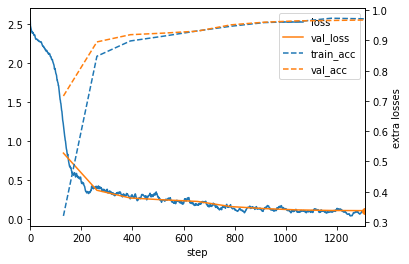

runtime: 123 s


In [13]:
tb_logger = pl.loggers.TensorBoardLogger("/home/mtadmin/projects/tensorboard_logs")

plotter = ProgressPlotter()
callbacks = [
    ProgressBar(),
    ProgressPrinter(),
    plotter,
    LearningRateMonitor(log_momentum=True),
]

# early_stop_callback = EarlyStopping(
#     monitor="val_loss",
#     mode="min",
#     patience=5,
#     verbose=True,
# )
# callbacks = [early_stop_callback] + callbacks


# model_checker = ModelCheckpoint(
#     monitor="val_loss",
#     mode="min",
#     save_last=True, 
#     save_top_k=1, 
#     filename="best_{epoch}",
# )
# callbacks += [model_checker]

# model = rn_model # baseline model
model = vit_model

max_epochs = 10
limit_train_batches = 0.1
# limit_train_batches = 0.1 # 1.0 by default/full set, use this to check training on a smaller train set, also exists for val and test set
trainer = pl.Trainer(
    max_epochs=max_epochs, 
    gpus=1,
    callbacks=callbacks,
    logger=[tb_logger],
    precision=16,
#     fast_dev_run=True, 
    limit_train_batches=limit_train_batches,
)

start_time = time.time()
trainer.fit(model, data)
print(f"runtime: {time.time() - start_time:.0f} s")

# we aim for ~99 %

In [14]:
# trainer.logger.log_dir
# trainer.checkpoint_callback.best_model_path

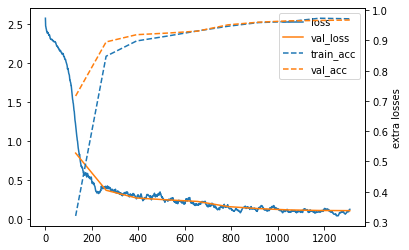

In [15]:
# static plot after training, useful when coming back after training finished
plotter.static_plot()

In [16]:
trainer.test(verbose=False)

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

[{'test_loss': 0.09611175209283829, 'test_acc': 0.9690999984741211}]

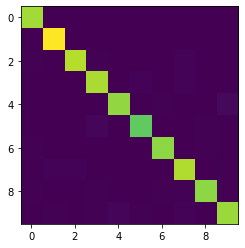

In [17]:
plt.imshow(model.test_confmatrix.compute().cpu())

## compute accuracy the hard way

In [18]:
model.eval()
all_targets = []
all_scores = []
for images, targets in tqdm(data.test_dataloader()):
    with torch.no_grad():
        scores = model(images).cpu().float()
        all_scores.append(scores)
        all_targets.append(targets)
        
scores = torch.cat(all_scores)
targets = torch.cat(all_targets)

  0%|          | 0/313 [00:00<?, ?it/s]

In [19]:
accuracy = (scores.max(1)[1] == targets).sum() / float(len(targets))
accuracy

tensor(0.9690)